Objetivo de este modelo base: El objetivo de este proyecto es desarrollar un modelo de predicción de precios de Bitcoin con métodos de aprendizaje automático utilizando datos de series temporales. Empleando algoritmos como la regresión lineal y las máquinas de soporte vectorial (SVM) con diferentes funciones de núcleo y parámetros, el proyecto busca identificar el modelo que minimice el error en la predicción de precios de cierre de Bitcoin.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [34]:
df_daily = pd.read_csv('bitcoin_2017_to_2023.csv', parse_dates=['timestamp'])
df_daily.set_index('timestamp', inplace=True)

daily_data = df_daily.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'quote_asset_volume': 'sum',
    'number_of_trades': 'sum',
    'taker_buy_base_asset_volume': 'sum',
    'taker_buy_quote_asset_volume': 'sum'
})

print(daily_data.head())


               open     high      low    close       volume  \
timestamp                                                     
2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377   
2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264   
2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763   
2017-08-20  4139.98  4211.08  4032.62  4086.29   467.083022   
2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060   

            quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
timestamp                                                                       
2017-08-17        3.454770e+06              3427                   616.248541   
2017-08-18        5.086958e+06              5233                   972.868710   
2017-08-19        1.549484e+06              2153                   274.336042   
2017-08-20        1.930364e+06              2321                   376.795947   
2017-08-21        2.797232e+06              3972                   557.3

In [35]:
daily_data.shape, daily_data.columns

((2176, 9),
 Index(['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
        'number_of_trades', 'taker_buy_base_asset_volume',
        'taker_buy_quote_asset_volume'],
       dtype='object'))

In [36]:
df_daily['day_of_week'] = df_daily.index.dayofweek

In [37]:
X= daily_data[['open', 'high', 'low', 'volume', 'quote_asset_volume', 'number_of_trades']]
# 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'
y = daily_data['close'].shift(-1)

In [38]:
X = X[:-1]
y = y[:-1]

In [39]:
X.shape, y.shape

((2175, 6), (2175,))

In [40]:
prediction_days = 60
X_train = X[:len(X)-prediction_days]
y_train = y[:len(y)-prediction_days]
X_test = X[len(X)-prediction_days:]
y_test = y[len(y)-prediction_days:]

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
# Definir el número de timesteps (ventana de tiempo)
timesteps = 20

# Crear secuencias para X_train y X_test
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i + timesteps])  # Extrae una ventana de tiempo de tamaño "timesteps"
        ys.append(y.iloc[i + timesteps])  # Valor a predecir después de la ventana de tiempo
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, timesteps)

# Comprobación de las nuevas formas
print("Forma de X_train_seq:", X_train_seq.shape)
print("Forma de X_test_seq:", X_test_seq.shape)
print("Forma de y_train_seq:", y_train_seq.shape)
print("Forma de y_test_seq:", y_test_seq.shape)

Forma de X_train_seq: (2095, 20, 6)
Forma de X_test_seq: (40, 20, 6)
Forma de y_train_seq: (2095,)
Forma de y_test_seq: (40,)


In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler_y = MinMaxScaler()
y_train_seq_scaled = scaler_y.fit_transform(y_train_seq.reshape(-1, 1))
y_test_seq_scaled = scaler_y.transform(y_test_seq.reshape(-1, 1))

In [45]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

optimizer = Adam(learning_rate=0.0001)
# Construir el modelo
regressorGRU = Sequential()
regressorGRU.add(GRU(units=128, return_sequences=True, input_shape=(timesteps, X_train_seq.shape[2]), activation = 'tanh'))
regressorGRU.add(Dropout(0.4))  # Dropout después de la capa GRU
regressorGRU.add(GRU(units=64, return_sequences=False, activation='tanh'))  # Segunda capa GRU
regressorGRU.add(Dropout(0.4))
regressorGRU.add(Dense(units=1))  # Capa de salida para predicción de un valor

# Compilar el modelo
regressorGRU.compile(optimizer=optimizer, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=False)
# Entrenar el modelo
history = regressorGRU.fit(X_train_seq, y_train_seq_scaled, epochs=100, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0930 - val_loss: 0.0307
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0301 - val_loss: 0.0032
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0214 - val_loss: 0.0037
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0206 - val_loss: 0.0044
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0186 - val_loss: 0.0031
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0125 - val_loss: 0.0013
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0129 - val_loss: 0.0021
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0135 - val_loss: 0.0071
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0123 - val_loss: 9.7206e-04
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0109 - val_loss: 8.7564e-04
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0099 - val_loss: 0.0012
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - 

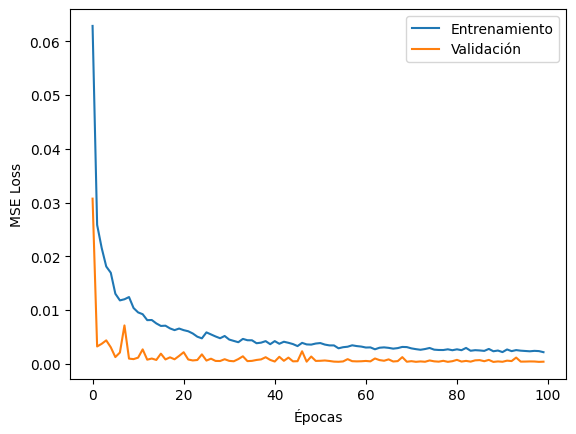

In [46]:
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [47]:
y_pred_scaled = regressorGRU.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


In [48]:
mse_gru = mean_squared_error(y_test_seq_scaled, y_pred_scaled)
mae_gru  = mean_absolute_error(y_test_seq_scaled, y_pred_scaled)

In [49]:
print("Resultados de GRU:")
print(f"MSE: {mse_gru:.6f}")
print(f"MAE: {mae_gru:.6f}\n")

Resultados de GRU:
MSE: 0.000125
MAE: 0.008585



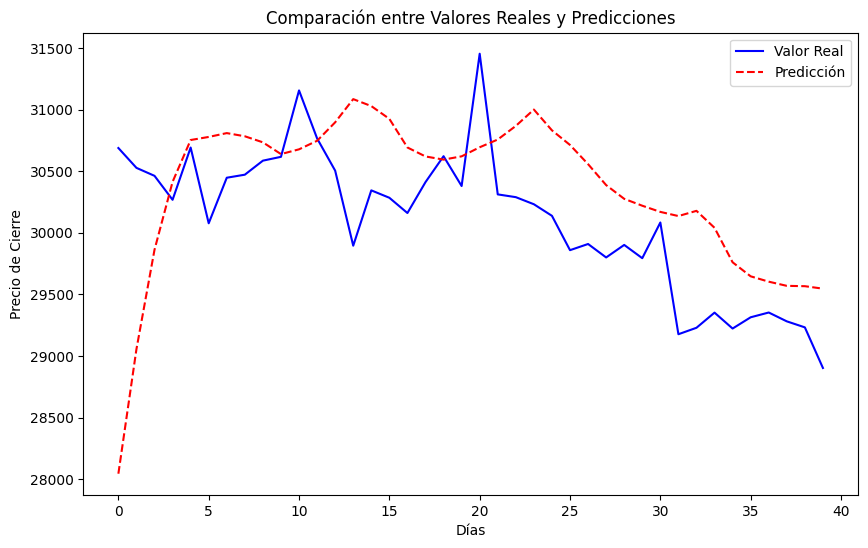

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Valor Real', color='blue')
plt.plot(y_pred, label='Predicción', color='red', linestyle='dashed')
plt.xlabel('Días')
plt.ylabel('Precio de Cierre')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.legend()
plt.show()


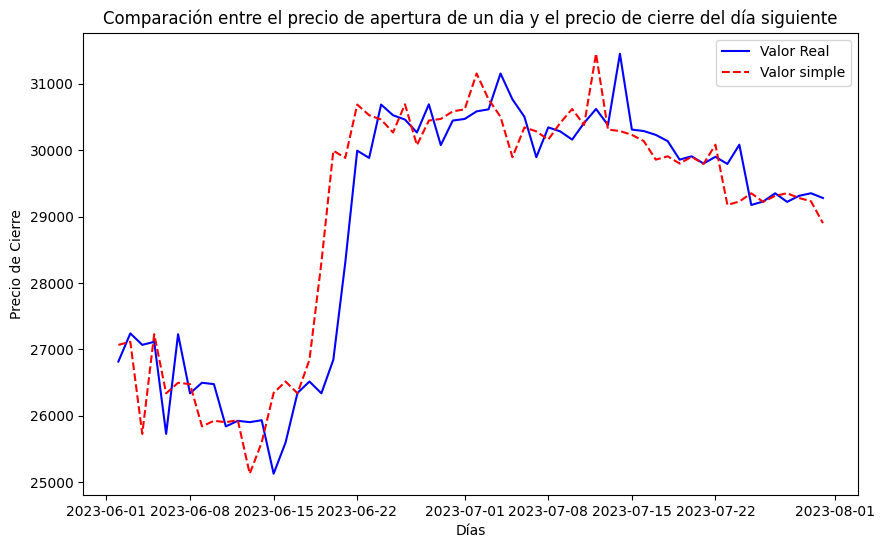

In [51]:
import matplotlib.pyplot as plt

## Ejemplo de grafica al igualar el precio de apertura de un dia antes con el precio de cierre de un día despues
plt.figure(figsize=(10, 6))
plt.plot(X_test['open'], label='Valor Real', color='blue')
plt.plot(y_test, label='Valor simple', color='red', linestyle='dashed')
plt.xlabel('Días')
plt.ylabel('Precio de Cierre')
plt.title('Comparación entre el precio de apertura de un dia y el precio de cierre del día siguiente')
plt.legend()
plt.show()